In [1]:
import os
import sys
sys.path.append('/home/fruitspec-lab/FruitSpec/Code/fsCounter')
from omegaconf import OmegaConf
import pyzed.sl as sl
import cv2
import numpy as np
from scipy.stats import gaussian_kde
import kornia as K
from tqdm import tqdm
import numpy as np
import collections
import pandas as pd
from vision.misc.help_func import get_repo_dir, scale_dets, validate_output_path, scale
from vision.depth.zed.svo_operations import get_frame, get_depth, get_point_cloud, get_dimensions, sl_get_dimensions

repo_dir = get_repo_dir()
sys.path.append(os.path.join(repo_dir, 'vision', 'detector', 'yolo_x'))

from vision.pipelines.detection_flow import counter_detection
from vision.pipelines.misc.filters import filter_by_distance, filter_by_size, filter_by_height, sort_out
from vision.tracker.fsTracker.score_func import compute_dist_on_vec
from vision.data.results_collector import ResultsCollector
from vision.tools.translation import translation as T
from vision.tools.camera import is_sturated
from vision.tools.color import get_hue
from vision.tools.video_wrapper import video_wrapper
from vision.tools.image_stitching import plot_2_imgs
import matplotlib.pyplot as plt
import seaborn as sns
import kornia as K


In [2]:
repo_dir = get_repo_dir()
pipeline_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/pipeline_config.yaml"
runtime_config = "/home/fruitspec-lab/FruitSpec/Code/fsCounter/vision/pipelines/config/runtime_config.yaml"
cfg = OmegaConf.load(pipeline_config)
args = OmegaConf.load(runtime_config)

validate_output_path(args.output_folder)

In [3]:
detector = counter_detection(cfg, args)
results_collector = ResultsCollector(rotate=args.rotate)
translation = T(cfg.translation.translation_size, cfg.translation.dets_only, cfg.translation.mode)

cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)

# Read until video is completed
print(f'Inferencing on {args.movie_path}\n')
number_of_frames = cam.get_number_of_frames()


loading checkpoint from /home/fruitspec-lab/FruitSpec/weights/Run_6_Dec_2022_1Class_aug_tasqV2/best_ckpt.pth
loaded checkpoint done.
Inferencing on /home/fruitspec-lab/Downloads/0.8m1sts/ZED_1.svo



In [4]:
measures_path = "/home/fruitspec-lab/Downloads/0.8m1sts/output/measures.csv"
measures_frame = pd.read_csv(measures_path)

In [5]:
def plot_image_grid(images, nrows, ncols, titles=None, figsize=None, xlabels=None, ylabels=None, cmap='viridis'):
    """
    Plots a grid of images using matplotlib.

    Parameters:
    images (list): A list of numpy arrays representing the images to be plotted.
    nrows (int): The number of rows in the grid.
    ncols (int): The number of columns in the grid.
    titles (list, optional): A list of strings representing the titles of the images. Must have the same length as images.
    figsize (tuple, optional): A tuple representing the size of the figure. Defaults to (ncols * 5, nrows * 5).
    xlabels (list, optional): A list of strings representing the x-axis labels for each image. Must have the same length as images.
    ylabels (list, optional): A list of strings representing the y-axis labels for each image. Must have the same length as images.
    cmap (str, optional): The color map to use when plotting the images. Defaults to 'viridis'.

    Returns:
    None
    """
    n_images = len(images)
    if isinstance(figsize, type(None)):
        figsize = (ncols * 5, nrows * 5)
    titles, xlabels, ylabels = (np.full(n_images, "") if isinstance(titles, type(None)) else arr
                                for arr in [titles, xlabels, ylabels])
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        image = images[i]
        ax.imshow(image)
        ax.set_title(titles[i])
        ax.set_xlabel(xlabels[i])
        ax.set_ylabel(ylabels[i])
    plt.tight_layout()
    plt.show()

def get_real_world_dims_with_correction(depth_map, fx = 1065.98388671875, fy = 1065.98388671875, resized = True):
    """
    calculates each pixel size based on trigo
    :param depth_map: distance_map to each point or an empty string
    :return: size for each pixel
    """
    pic_size = depth_map.shape
    if resized:
        resize_fator_x = 1080/pic_size[0]
        resize_fator_y = 1920/pic_size[1]
    else:
        resize_fator_x = 1
        resize_fator_y = 1
    x0 = pic_size[1] /2
    y0 = pic_size[0] /2
    pixel_mm = 0.002
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(1, pic_size[1]+1)
    X_pix_dist_from_center = np.abs(np.array([x_range for i in range(pic_size[0])]) - x0)
    X_mm_dist_from_center = (X_pix_dist_from_center * (X_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (X_mm_dist_from_center/focal_len)))
    gamma = np.arctan((X_pix_dist_from_center+1)*pixel_mm/focal_len)
    size_x = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_x
    size_y = (np.tan(gamma) - np.tan(gamma-beta))*depth_map*2*resize_fator_y
    return size_x, size_y, size_x*size_y

def get_pix_size(depth, box, fx = 1065.98388671875, fy = 1065.98388671875,
                 pixel_mm = 0.0002, org_size = np.array([1920,1080])):
    """
    Calculates the size of a pixel in millimeters given a distance from the camera and the intrinsic parameters of the camera.

    Args:
        depth (float): The depth from the camera to the object in meters.
        box (list): ROI for pixel size int hte following format: x1,y1,x2,y2.
        fx (float): The focal length of the camera in the x direction in pixels. Default is 1065.98388671875.
        fy (float): The focal length of the camera in the y direction in pixels. Default is 1065.98388671875.
        pixel_mm (float): The size of a pixel in millimeters. Default is 0.002.
        org_size (ndarray): The size of the image in pixels. Default is np.array([1920, 1080]).

    Returns:
        size_pix (float): The size of a pixel
    """
    x1,y1,x2,y2 = box
    y0, x0 = org_size/2
    focal_len = (fx + fy) / 2 * pixel_mm
    x_range = np.arange(x1, x2+1)
    x_pix_dist_from_center = np.abs(np.array([x_range for i in range(y2-y1)]) - x0)
    x_mm_dist_from_center = (x_pix_dist_from_center * (x_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (x_mm_dist_from_center/focal_len)))
    gamma = np.arctan((x_mm_dist_from_center+1)*pixel_mm/focal_len)
    size_pix_x = (np.tan(gamma) - np.tan(gamma-beta))*depth*2
    
    y_range = np.arange(y1, y2+1)
    y_pix_dist_from_center = np.abs(np.array([y_range for i in range(x2-x1)]) - y0).T
    y_mm_dist_from_center = (y_pix_dist_from_center * (y_pix_dist_from_center+1)*(pixel_mm**2))
    beta = np.arctan(0.001/(focal_len + (y_mm_dist_from_center/focal_len)))
    gamma = np.arctan((y_mm_dist_from_center+1)*pixel_mm/focal_len)
    size_pix_y = (np.tan(gamma) - np.tan(gamma-beta))*depth*2
    return size_pix_x, size_pix_y


def cut_center_of_box(image, margin=0.05):
    """
    Cuts the center of the box.
    
    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - margin: A float representing the percentage of margin to remove from the center of the image.

    Returns:
    - A 3D Numpy array representing the cropped image with the outside of the box removed.
    """
    t, l, (b, r) = 0 ,0, image.shape[:2]
    y_max, x_max = image.shape[:2]
    h_m = int((b-t)*margin)
    w_m = int((r-l)*margin)
    cut_box = image[max(0, t+h_m):min(y_max, b-h_m), max(0, l+w_m):min(x_max, r-w_m)]
    return cut_box


def xyz_center_of_box(image, method="median"):
    """
    Calculates the median or mean x, y, and z coordinates of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the x, y, and z coordinates of the center of the fruit.
    """
    if method=="median":
        cut_box = cut_center_of_box(image, 0.025)
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    elif method=="mean":
        cut_box = cut_center_of_box(image, 0.4)
        x_median = np.nanmean(cut_box[:, :, 0])
        y_median = np.nanmean(cut_box[:, :, 1])
        z_median = np.nanmean(cut_box[:, :, 2])
    else: # calculates only on the edge of the cut box
        cut_box = cut_center_of_box(image, 0.25).copy()
        if cut_box.shape[0] > 10 and cut_box.shape[1] > 10:
            cut_box[5:-5,5:-5] = np.nan
        x_median = np.nanmedian(cut_box[:, :, 0])
        y_median = np.nanmedian(cut_box[:, :, 1])
        z_median = np.nanmedian(cut_box[:, :, 2])
    return x_median, y_median, z_median


def dist_to_box_center(image, method="median"):
    """
    Calculates the distance from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the distance from the camera to the center of the fruit.
    """
    return np.sum(np.array(list(xyz_center_of_box(image, method)))**2)

def depth_to_box_center(image, method="median"):
    """
    Calculates the depth from the camera to the center of the fruit.

    Args:
    - image: A 3D Numpy array representing a cropped xyz image.
    - method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A float representing the depth from the camera to the center of the fruit.
    """
    return xyz_center_of_box(image, method)[2]

def get_dims_w_pixel_size(pc_img, box, center_method="median"):
    """
    Calculates the width and height of a 2D bounding box in millimeters, based on the pixel size of the image.

    Args:
    - pc_img: A 3D Numpy array representing a point cloud image.
    - box: A tuple of integers representing the (x1, y1, x2, y2) coordinates of the bounding box.
    - center_method: A string representing the method to use to calculate the center of the fruit. Must be either "median" or "mean".

    Returns:
    - A tuple of floats representing the width and height of the bounding box in millimeters.
    """
    dist = depth_to_box_center(pc_img, center_method)
    size_pix_x, size_pix_y = get_pix_size(dist, box)
    height_indx = np.argmax(np.sum(1 - np.isnan(pc_img[:, :, 1]), axis=1))
    width_indx = np.argmax(np.sum(1 - np.isnan(pc_img[:, :, 1]), axis=0))
    width = np.sum(size_pix_x[:, width_indx]) # to return in cm
    height = np.sum(size_pix_y[height_indx, :]) # to return in cm
    return width, height 

def hue_filtering(rgb_crop, nstds = 1):
    """
    Apply hue filtering to an RGB image crop.

    Parameters:
        rgb_crop (numpy.ndarray): Input RGB image crop as a numpy array.
        nstds (float): Number of standard deviations used to determine the upper and lower hue thresholds.
    
    Returns:
        numpy.ndarray: mask where True value indicated what was filtered out
    """
    rgb_c = rgb_crop.copy()
    hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
    hue, sat, v = cv2.split(hsv.copy())
    hist_vals, hist_bins = np.histogram(hue, bins = 50)
    mode = hist_bins[np.argmax(hist_vals)]
    if mode > 35: # greener area
        nstds *= 1.5
    hue_std = np.std(hue)
    upper_limit = mode + nstds*hue_std
    lower_limit = mode - nstds*hue_std
    logical_vec = np.any([hue > upper_limit, hue < lower_limit], axis = 0)
    return logical_vec

In [6]:
def get_track_id_frames(measures_frame, track_id):
    """
    Returns a numpy array of frames associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve frames for.

    Returns:
    numpy.ndarray: A 1-dimensional array of frames associated with the given track ID.
    """
    return measures_frame[measures_frame["track_id"] == track_id]["frame"].values

def get_track_id_boxes(measures_frame, track_id):
    """
    Returns a numpy array of bounding boxes associated with a given track ID.

    Parameters:
    measures_frame (pandas.DataFrame): A dataframe containing measurements data.
    track_id (int): The ID of the track to retrieve bounding boxes for.

    Returns:
    numpy.ndarray: A 2-dimensional array of bounding boxes associated with the given track ID.
        Each row contains the x1, y1, x2, y2 coordinates of a bounding box in the format [x1, y1, x2, y2].
    """
    return measures_frame[measures_frame["track_id"] == track_id][["x1", "y1", "x2", "y2"]].values

def validate_bbox(crop, rgb_img):
    """
    Validates the given bounding box coordinates and ensures that they fall within the dimensions of the RGB image.

    Parameters:
    crop (tuple): A tuple containing the coordinates of the bounding box in the format (x1, y1, x2, y2).
        x1 and y1 are the coordinates of the top-left corner of the bounding box, and x2 and y2 are the coordinates of the bottom-right corner.
    rgb_img (numpy.ndarray): A numpy array representing the RGB image.

    Returns:
    tuple: A tuple containing the validated bounding box coordinates in the format (x1, y1, x2, y2).
        The returned coordinates ensure that the bounding box falls entirely within the dimensions of the RGB image.
    """
    x1, y1, x2, y2 = crop
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    h, w = rgb_img.shape[:2]
    x2 = min(x2, w-1)
    y2 = min(y2, h-1)
    return x1, y1, x2, y2


def get_track_id_images(measures_frame, track_id, args):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    rgb_images, pc_images = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, crop = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
        rgb_images.append(rgb_img[y1:y2,x1:x2])
        pc_images.append(pc_img[y1:y2,x1:x2])
    cam.close()
    return rgb_images, pc_images

def kde_filtering(centers, thresh=0.5):
    """
    Applies a Kernel Density Estimation (KDE) filtering on a set of 3D points.

    Args:
        centers (np.ndarray): A numpy array of shape (n, 3) representing the 3D coordinates of the points to filter.
        thresh (float): A threshold value to filter out points with low density. Default is 0.5.

    Returns:
        np.ndarray: A numpy array of shape (n, 3) where each filtered 3D points is replaced with np.nan
    """
    finite_logical = np.all(np.isfinite(centers), axis=1)
    if not sum(finite_logical):
        return centers
    finite_centers = centers[finite_logical].copy()
    kernel = gaussian_kde(finite_centers.T)
    points_density = np.full(len(centers), np.nan)
    points_density[finite_logical] = kernel(finite_centers.T)
    points_density = points_density/np.nansum(points_density)
    filtered_center = centers.copy()
    filtered_center[points_density <thresh/ len(finite_logical)] = np.nan
    return filtered_center

In [7]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 7)
# plot_2_imgs(rgb_images[0], pc_images[0][:,:,2])

In [8]:
# for track_id in [6,7,8,28]:
#     print(track_id)
#     frame_numbers = get_track_id_frames(measures_frame, track_id)
#     boxes = get_track_id_boxes(measures_frame, track_id)
#     rgb_images, pc_images = [], []
#     for frame, crop in tqdm(zip(frame_numbers, boxes)):
#         rgb_img, _, pc_img = cam.get_zed(frame)
#         x1,y1,x2,y2 = validate_bbox(crop, rgb_img)
#         rgb_images.append(rgb_img[y1:y2,x1:x2])
#         pc_images.append(pc_img[y1:y2,x1:x2])
#     plot_image_grid(rgb_images,5,5)

In [9]:
def filter_xyz_outliers(crop, nstd=2, as_points=True):
    """
    Filters out the outliers from the 3D points in the given crop.

    Args:
        crop (ndarray): A numpy array of shape (height, width, 3) containing the 3D points.
        nstd (float): The number of standard deviations to consider for defining the range of valid values.
        as_points (bool): Whether to return the filtered 3D points as an array of points or as an array of the same shape
            as the input crop.

    Returns:
        ndarray: A numpy array of filtered 3D points. If as_points is True, this is a numpy array of shape (n, 3),
            where n is the number of valid 3D points. Otherwise, it is a numpy array of the same shape as the input crop.
    """
    centers = crop.reshape(-1, 3)
    filtered_centers = centers.copy()
    channel_medians = np.nanmedian(centers, axis=0)
    channel_stddevs = np.nanstd(centers, axis=0)
    channel_max = channel_medians + nstd * channel_stddevs
    channel_min = channel_medians - nstd * channel_stddevs
    valid_mask = np.all((centers >= channel_min) & (centers <= channel_max), axis=1)
    filtered_centers[~valid_mask] = np.nan
    if as_points:
        return filtered_centers
    return filtered_centers.reshape(crop.shape)


def ellipsoid_fit(filtered_center):
    """
    Fits an ellipsoid to a set of 3D points using least squares estimation.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]

    #   Assemble the f matrix
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

In [10]:
from sklearn.linear_model import RANSACRegressor
def ellipsoid_fit_ransac(filtered_center, num_iterations=100, inlier_threshold=0.1):
    """
    Fits an ellipsoid to a set of 3D points using RANSAC.

    Args:
    - filtered_center (numpy array): An N x 3 array of N 3D points in the form (x, y, z).
    - num_iterations (int): The number of iterations to run RANSAC for.
    - inlier_threshold (float): The maximum distance from a point to the fitted ellipsoid to be considered an inlier.

    Returns:
    - radius (float): The radius of the fitted ellipsoid.
    - semi_axis_1 (float): The length of the semi-major axis of the ellipsoid.
    - semi_axis_2 (float): The length of the semi-intermediate axis of the ellipsoid.
    - semi_axis_3 (float): The length of the semi-minor axis of the ellipsoid.
    """
    filtered_center[np.abs(filtered_center) > 2] = np.nan
    A = np.column_stack([filtered_center, np.ones(len(filtered_center))])
    good_rows = np.all(np.isfinite(A), axis=1)
    A = A[good_rows]
    if len(A) < 5:
        return np.nan, np.nan, np.nan, np.nan
    f = np.zeros((len(A),1))
    f[:,0] = np.sum(A[:,:3]**2, axis = 1)

    model = RANSACRegressor(estimator=None, residual_threshold=inlier_threshold, max_trials=num_iterations)
    model.fit(A,f)

    # Extract the coefficients of the fitted ellipsoid
    coef = model.estimator_.coef_[0]
    C = np.abs(np.concatenate([coef[:3], [1], coef[3:]]))

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)

    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2]) 

def get_width(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginy = np.round(margin / 2 * h).astype(np.int16)
    crop_marg = crop[marginy:-marginy, :, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=0)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        width = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        width = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return width


def get_height(crop, margin=0.2, fixed_z=True, max_z=1):
    h, w, c = crop.shape
    marginx = np.round(margin / 2 * w).astype(np.int16)
    crop_marg = crop[:, marginx:-marginx, :]
    crop_marg[crop_marg[:, :, 2] > max_z] = np.nan
    vec = np.nanmean(crop_marg, axis=1)
    vec = vec[np.isfinite(vec[:, 2])]
    if len(vec) < 2:
        return np.nan
    if fixed_z:
        height = np.sqrt(np.sum((vec[0, :-1] - vec[-1, :-1]) ** 2)) * 1000
    else:
        height = np.sqrt(np.sum((vec[0, :] - vec[-1, :]) ** 2)) * 1000
    return height

def get_cropped_point_cloud(bbox, point_cloud, margin=0.2):
    crop = point_cloud[max(int(bbox[1]), 0):int(bbox[3]), max(int(bbox[0]), 0): int(bbox[2]), :-1].copy()
    return crop

  0%|                                                                                                                                                                                                   | 0/107 [00:00<?, ?it/s]/tmp/ipykernel_32149/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_32149/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:11<00:00,  9.23it/s]


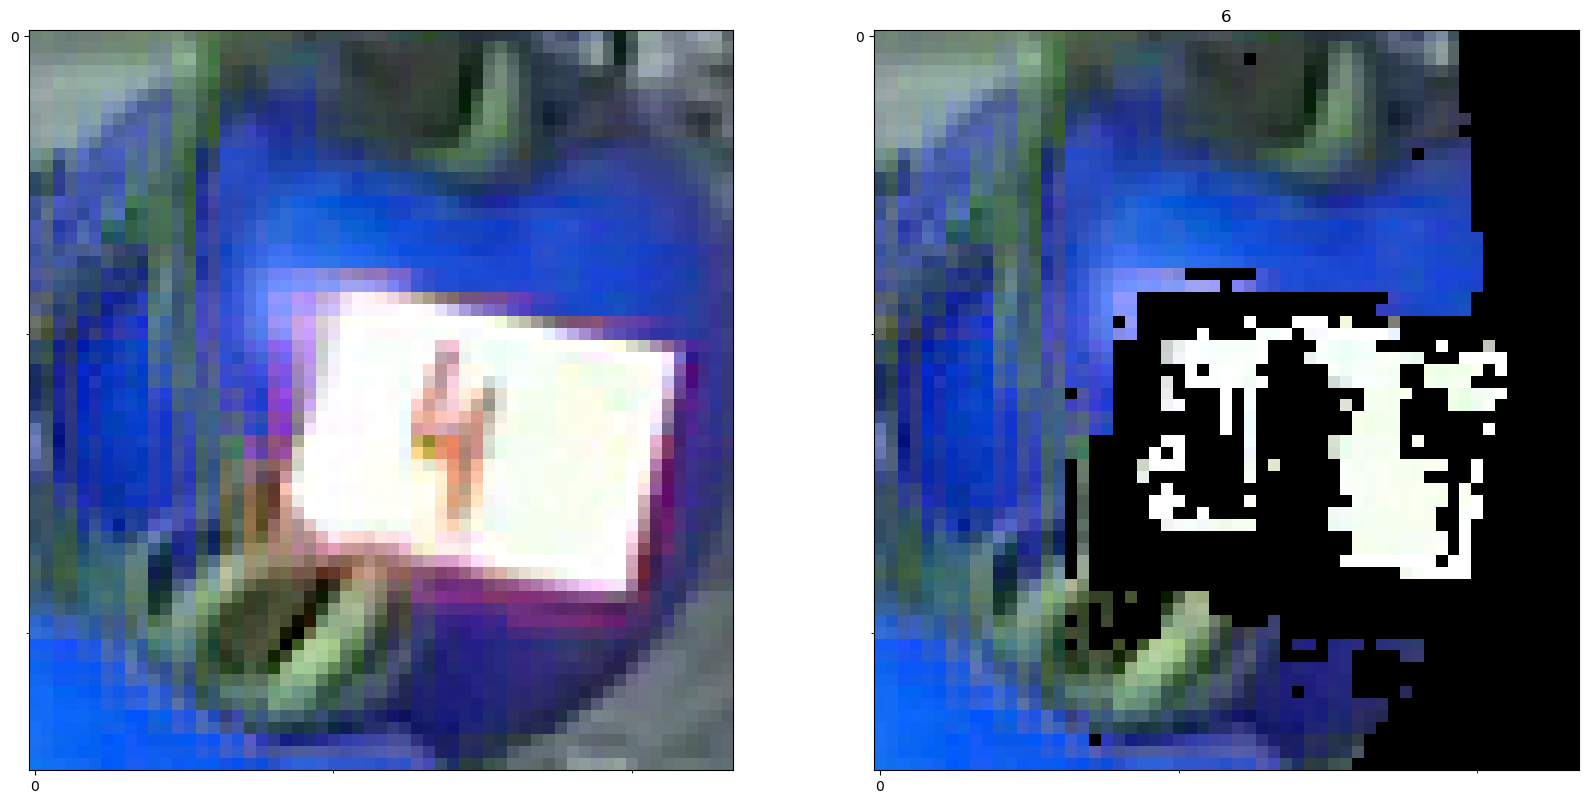

/tmp/ipykernel_32149/807952457.py:82: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_32149/807952457.py:83: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_32149/807952457.py:84: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 54.75995416629878 0.7471040811549724 49.85880058414603 0.6774156730995856 
 pix med: 
 55.16011852567067 0.7710874754486348 50.2224481523398 0.6475531235149643 
 margin 0.2: 
 47.3923546340421 0.46003517395173366 47.143767370241825 0.841898675263477 
 margin 0.5: 
 47.53716683415609 0.4674718770955724 47.77818712814946 0.8356556530161576 
 margin 0.8: 
 47.563823131478834 0.46112987750571044 47.075301582846684 0.8660867303946093 
 margin_f0.2: 
 47.420105540028246 0.7338930689371648 47.138122267255156 0.844352310713517 
 margin 0.5_f: 
 47.62163159446182 0.7118652946633938 47.78456701853565 0.8398082741026037 
 margin 0.8_f: 
 47.683334099912194 0.6894298011532836 47.07213672243546 0.8630353536178039


  0%|                                                                                                                                                                                                   | 0/107 [00:00<?, ?it/s]/tmp/ipykernel_32149/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:11<00:00,  8.98it/s]


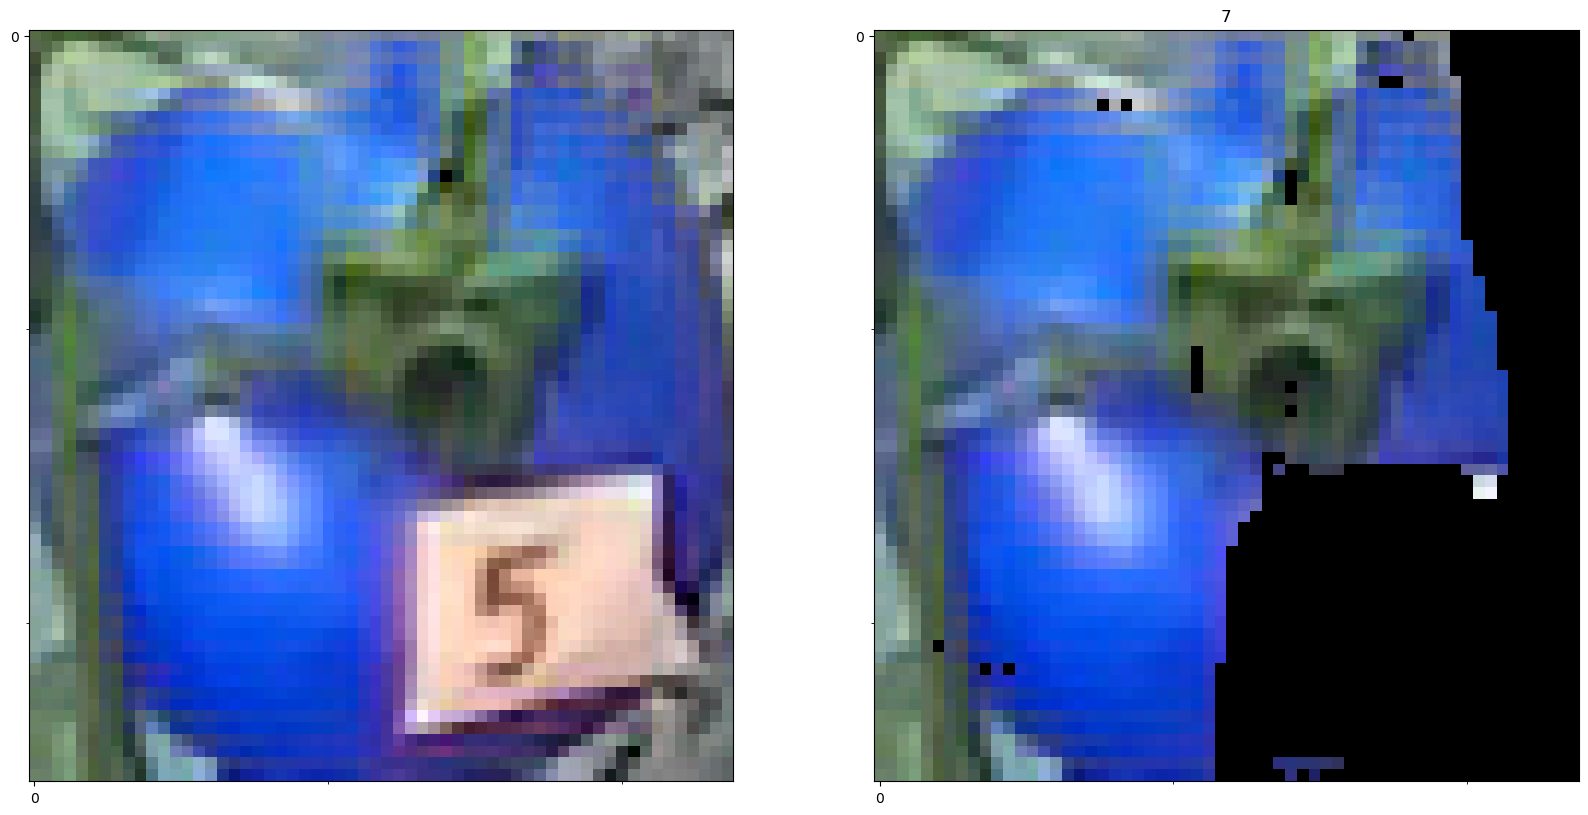

/tmp/ipykernel_32149/807952457.py:82: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_32149/807952457.py:83: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_32149/807952457.py:84: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 57.780730961933045 2.1366346568471695 50.77314057401047 0.47193540942568346 
 pix med: 
 58.09835828806705 2.182254261524587 51.0513390404791 0.48646722515980384 
 margin 0.2: 
 48.93656043666545 1.3896191072506299 58.79264485056155 1.9889061971592712 
 margin 0.5: 
 48.194004727579724 1.1799584767270852 57.91201268401101 2.2167907626666095 
 margin 0.8: 
 43.316485656199056 4.448856414744552 57.052143927768014 2.36448406864101 
 margin_f0.2: 
 44.69216454808957 4.302995355164995 58.890740656964134 1.9355624440546846 
 margin 0.5_f: 
 44.66275752426308 4.357480371539572 57.89713895766535 2.2268971463604608 
 margin 0.8_f: 
 42.34163960981592 4.4958613019421225 57.00426158782478 2.384043192098084


  0%|                                                                                                                                                                                                   | 0/107 [00:00<?, ?it/s]/tmp/ipykernel_32149/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_32149/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 107/107 [00:12<00:00,  8.76it/s]


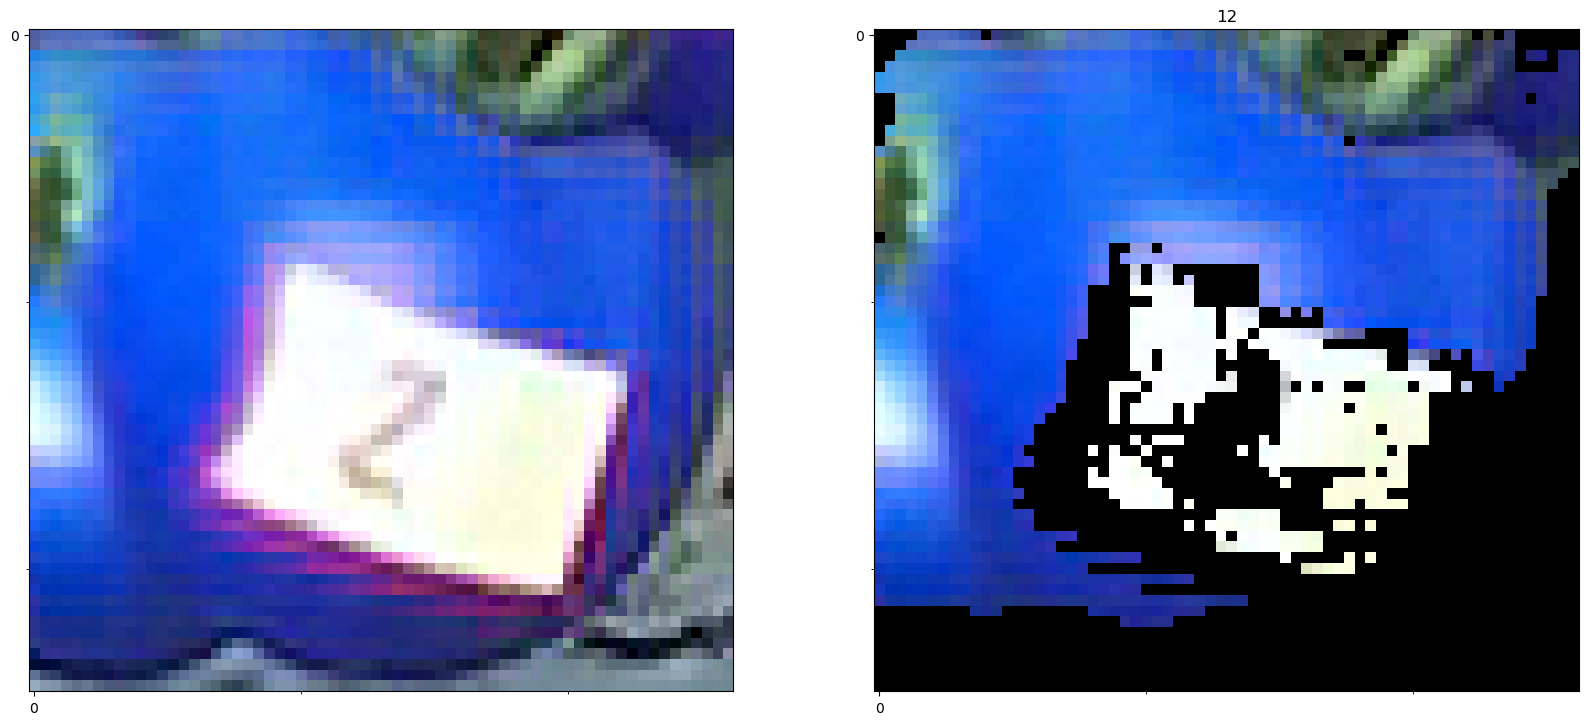

/tmp/ipykernel_32149/807952457.py:82: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_32149/807952457.py:83: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_32149/807952457.py:84: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 52.08486948729911 1.118681717075545 49.66981969075337 2.1517280657993507 
 pix med: 
 53.205171940551644 1.3793691362907492 50.74490504278781 2.4568655793678356 
 margin 0.2: 
 58.86571520121298 3.376475087714087 61.06050173255885 5.4650596105542535 
 margin 0.5: 
 52.466656490464075 3.18676700176482 61.459405713270755 6.056392021595962 
 margin 0.8: 
 51.36456476332985 3.3594918251892127 61.355641686192186 6.0319209264704545 
 margin_f0.2: 
 58.72019679746895 3.353739434815577 60.865960527803296 5.665174564250946 
 margin 0.5_f: 
 52.46382906475914 3.1849504601628693 61.1441075871481 6.428402813808379 
 margin 0.8_f: 
 51.36487612100405 3.3596916053753167 60.750531537510525 6.847692959518627


  0%|                                                                                                                                                                                                    | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_32149/2130430607.py:45: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=0)
/tmp/ipykernel_32149/2130430607.py:61: RuntimeWarning: Mean of empty slice
  vec = np.nanmean(crop_marg, axis=1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.29it/s]


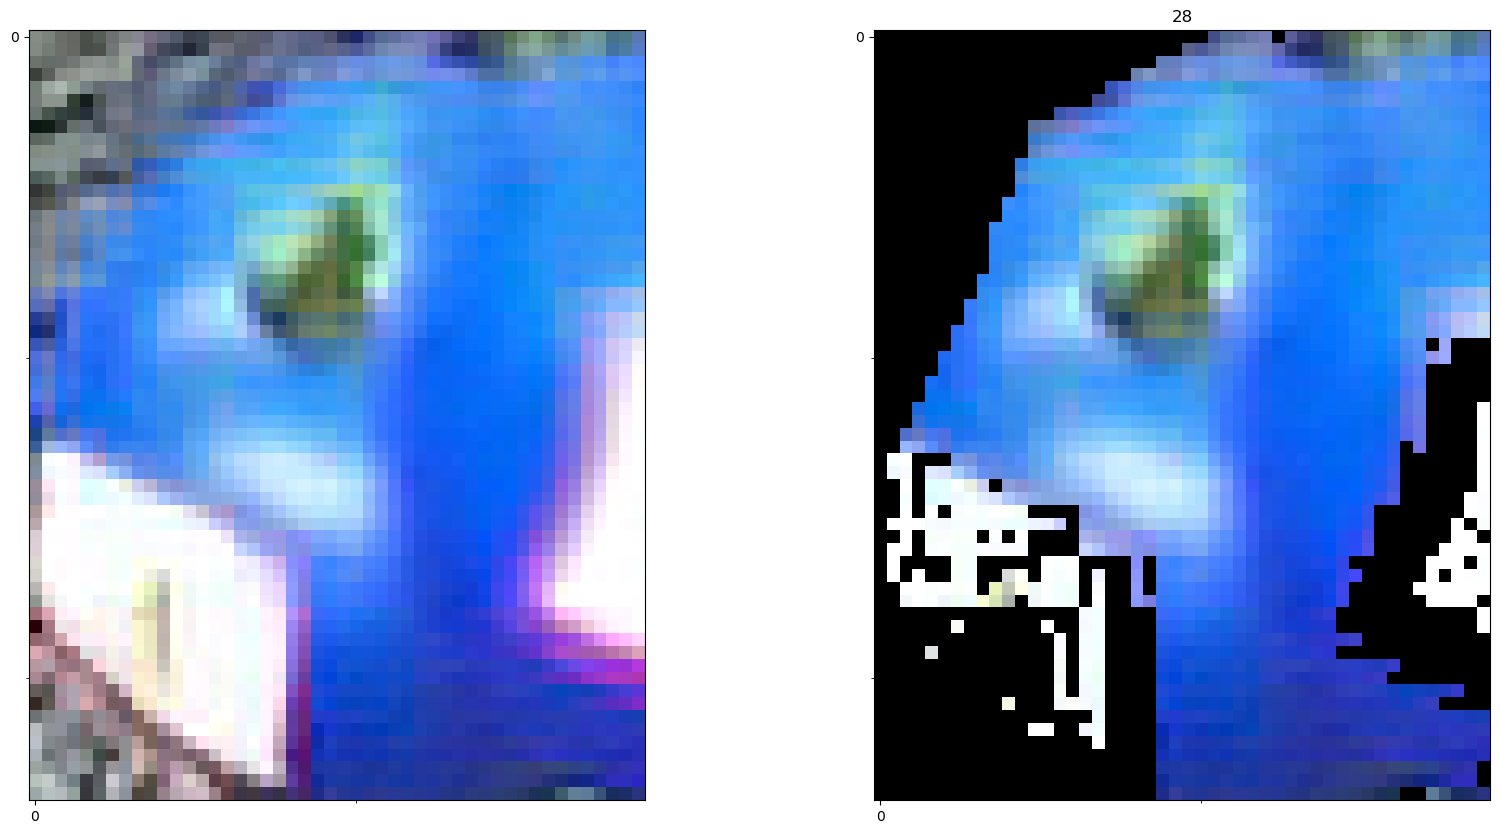

ellipse: 
 nan nan nan nan nan nan 
 pix mean: 
 49.518326464561326 1.497100102223106 36.80307886789686 1.229112774494819 
 pix med: 
 49.51457126796333 1.4911922662948955 36.80039496823358 1.2285473355527072 
 margin 0.2: 
 49.71936819228259 1.7114065026610112 55.17030575058677 3.392739366277628 
 margin 0.5: 
 49.82164908539165 1.815890432451203 52.248237485235386 2.89014302236022 
 margin 0.8: 
 51.05799402702939 3.0794853054111018 46.28234322775494 7.203159708824027 
 margin_f0.2: 
 50.46040700240569 1.5219060291710718 55.017513646320864 3.3947636040435376 
 margin 0.5_f: 
 49.65933852575042 1.5017563441495654 51.64419385519895 2.588242071993823 
 margin 0.8_f: 
 50.445037470622495 3.4229838519111464 45.10216889056292 8.504272639832712


/tmp/ipykernel_32149/807952457.py:82: RuntimeWarning: Mean of empty slice
  print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_32149/807952457.py:83: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_h), np.nanstd(ellps_h),
/tmp/ipykernel_32149/807952457.py:84: RuntimeWarning: Mean of empty slice
  np.nanmean(ellps_z), np.nanstd(ellps_z),


In [11]:
for track_id in [6,7,12,28]:
# for track_id in range(30):
    cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
    frame_numbers = get_track_id_frames(measures_frame, track_id)
    boxes = get_track_id_boxes(measures_frame, track_id)
    ellps_w, ellps_h, ellps_z = [], [], []
    pix_size_w_mean, pix_size_h_mean = [], []
    pix_size_w_med, pix_size_h_med = [], []
    margin_h_2, margin_w_2 = [], []
    margin_h_5, margin_w_5 = [], []
    margin_h_8, margin_w_8 = [], []
    margin_h_2_f, margin_w_2_f = [], []
    margin_h_5_f, margin_w_5_f = [], []
    margin_h_8_f, margin_w_8_f = [], []
    for i in tqdm(range(len(frame_numbers))):
        frame, box = frame_numbers[i], boxes[i]
        rgb_img, _, pc_img = cam.get_zed(frame)
        x1,y1,x2,y2 = validate_bbox(box, rgb_img)
        pc_crop = pc_img[y1:y2, x1:x2,:3]
        rgb_crop = rgb_img[y1:y2, x1:x2]
#         filtered_center = kde_filtering(pc_crop[:,:,:3].reshape(-1,3))
#         _, width, height, z_w = ellipsoid_fit_ransac(filtered_center)
#         if width > 200 or height > 200 or z_w > 200: #if fruits are too big its probably due to noise
#             width, height, z_w = np.nan, np.nan, np.nan
#         ellps_w.append(width*100), ellps_h.append(height*100), ellps_z.append(z_w*100)
        pc_crop_f = pc_crop.copy()
        rgb_crop_c = rgb_crop.copy()
        filter_vec = hue_filtering(rgb_crop, nstds = 1.5)
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        filter_vec = np.isnan(filter_xyz_outliers(pc_crop, 2, False))
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        
        width, height = get_dims_w_pixel_size(pc_crop_f, [x1,y1,x2,y2], "mean")
        pix_size_w_mean.append(width*100), pix_size_h_mean.append(height*100)
        width, height = get_dims_w_pixel_size(pc_crop_f, [x1,y1,x2,y2], "median")
        pix_size_w_med.append(width*100), pix_size_h_med.append(height*100)
        

        width = get_width(pc_crop, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.2, fixed_z=True, max_z=1)
        margin_h_2.append(height)
        margin_w_2.append(width)
        
        width = get_width(pc_crop, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.5, fixed_z=True, max_z=1)
        margin_h_5.append(height)
        margin_w_5.append(width)
        
        width = get_width(pc_crop, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop, 0.8, fixed_z=True, max_z=1)
        margin_h_8.append(height)
        margin_w_8.append(width)
        
        pc_crop_f = pc_crop.copy()
        rgb_crop_c = rgb_crop.copy()
        
        filter_vec = hue_filtering(rgb_crop, nstds = 1.5)
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        filter_vec = np.isnan(filter_xyz_outliers(pc_crop, 2, False))
        rgb_crop_c[filter_vec] = 0
        pc_crop_f[filter_vec] = np.nan
        
        width = get_width(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.2, fixed_z=True, max_z=1)
        margin_h_2_f.append(height)
        margin_w_2_f.append(width)
        
        width = get_width(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.5, fixed_z=True, max_z=1)
        margin_h_5_f.append(height)
        margin_w_5_f.append(width)
        
        width = get_width(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        height = get_height(pc_crop_f, 0.8, fixed_z=True, max_z=1)
        margin_h_8_f.append(height)
        margin_w_8_f.append(width)

    plot_2_imgs(rgb_crop, rgb_crop_c, track_id)
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8),
          
                  "\n margin_f0.2: \n", 
        np.nanmean(margin_w_2_f), np.nanstd(margin_w_2_f),
          np.nanmean(margin_h_2_f), np.nanstd(margin_h_2_f),
                  "\n margin 0.5_f: \n", 
        np.nanmean(margin_w_5_f), np.nanstd(margin_w_5_f),
          np.nanmean(margin_h_5_f), np.nanstd(margin_h_5_f),
                  "\n margin 0.8_f: \n", 
        np.nanmean(margin_w_8_f), np.nanstd(margin_w_8_f),
          np.nanmean(margin_h_8_f), np.nanstd(margin_h_8_f))

In [12]:
s

NameError: name 's' is not defined

In [ ]:
    print("ellipse: \n", np.nanmean(ellps_w), np.nanstd(ellps_w),
          np.nanmean(ellps_h), np.nanstd(ellps_h),
          np.nanmean(ellps_z), np.nanstd(ellps_z),
          "\n pix mean: \n",
         np.nanmean(pix_size_w_mean), np.nanstd(pix_size_w_mean),
          np.nanmean(pix_size_h_mean), np.nanstd(pix_size_h_mean),
          "\n pix med: \n"
        ,np.nanmean(pix_size_w_med), np.nanstd(pix_size_w_med),
          np.nanmean(pix_size_h_med), np.nanstd(pix_size_h_med),
         "\n margin 0.2: \n", 
        np.nanmean(margin_w_2), np.nanstd(margin_w_2),
          np.nanmean(margin_h_2), np.nanstd(margin_h_2),
                  "\n margin 0.5: \n", 
        np.nanmean(margin_w_5), np.nanstd(margin_w_5),
          np.nanmean(margin_h_5), np.nanstd(margin_h_5),
                  "\n margin 0.8: \n", 
        np.nanmean(margin_w_8), np.nanstd(margin_w_8),
          np.nanmean(margin_h_8), np.nanstd(margin_h_8))

In [ ]:
track_id = 5
cam = video_wrapper(args.movie_path, args.rotate, args.depth_minimum, args.depth_maximum)
frame_numbers = get_track_id_frames(measures_frame, track_id)
boxes = get_track_id_boxes(measures_frame, track_id)
ellps_w, ellps_h, ellps_z = [], [], []
pix_size_w_mean, pix_size_h_mean = [], []
pix_size_w_med, pix_size_h_med = [], []
i = len(frame_numbers) -1
frame, box = frame_numbers[i], boxes[i]
rgb_img, _, pc_img = cam.get_zed(frame)
x1,y1,x2,y2 = validate_bbox(box, rgb_img)
pc_crop = pc_img[y1:y2, x1:x2,:3]
plt.imshow(rgb_img[y1:y2, x1:x2])
plt.title(track_id)
plt.show()

In [ ]:
cut_box_pc = cut_center_of_box(pc_crop, 0.1)
cut_box_rgb = cut_center_of_box(rgb_img[y1:y2, x1:x2], 0.1)
plot_2_imgs(cut_box_pc[:, :, 2], cut_box_rgb)

In [ ]:
def apply_sobol(det_crop, plot_change=False):
    """
    applies sobol filterning on image
    :param det_crop: image to apply filter on
    :param plot_change: flag to show the image after applying sobol
    :return: image after sobol filtering
    """
    torch_img = K.utils.image_to_tensor(det_crop)
    torch_img = torch_img[None, ...].float() / 255.
    torch_img = K.enhance.adjust_contrast(torch_img, 0.5)
    torch_img_gray = K.color.rgb_to_grayscale(torch_img)
    processed_img = K.filters.sobel(torch_img_gray, True, 1e-3) 
    if plot_change:
        plot_2_imgs(det_crop, processed_img.detach().numpy()[0, 0] > 0.05)
    return processed_img.detach().numpy()[0, 0]
out_img = apply_sobol(rgb_img[y1:y2, x1:x2], True)

In [ ]:
min_area = 5
out_img = out_img > 0.04
rgb_crop = rgb_img[y1:y2, x1:x2].copy()
contours, _ = cv2.findContours(out_img.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = []
for c in contours:
    if cv2.contourArea(c) >= min_area:
        filtered_contours.append(c)

mask = np.zeros_like(out_img).astype(np.uint8)
hull = cv2.convexHull(np.concatenate(filtered_contours))
cv2.drawContours(mask, [hull], 0, (255, 255, 255), -1)
plot_2_imgs(out_img, mask)

rgb_c = rgb_crop.copy()
rgb_c[np.logical_not(mask)] = 0
plot_2_imgs(rgb_crop, rgb_c)

In [ ]:
plot_2_imgs(rgb_crop, hue_filtering(rgb_crop))

In [ ]:
# rgb_images, pc_images = get_track_id_images(measures_frame, 0, args)
# hue_filtered = [hue_filtering(rgb_c) for rgb_c in rgb_images]
# plot_image_grid(hue_filtered, 5, np.ceil(hue_filtered/5))

In [ ]:
plt.imshow(rgb_c)

In [ ]:
hist_bins[np.argmax(hist_vals)] + 1*np.std(hue)

In [ ]:
hsv = cv2.cvtColor(rgb_c, cv2.COLOR_BGR2HSV)
hue, sat, v = cv2.split(hsv.copy())
rgb_crop = rgb_c.copy()
plot_2_imgs(rgb_c, hue)
rgb_crop[hue > 200] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 150] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 100] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 50] = 0
plot_2_imgs(rgb_c, rgb_crop)
rgb_crop[hue > 25] = 0
plot_2_imgs(rgb_c, rgb_crop)

In [ ]:
d2_border_points = np.where(out_img> 0.05)
spX=d2_border_points[0]
spY=d2_border_points[1]

A = np.zeros((len(spX),3))
A[:,0] = spX*2
A[:,1] = spY*2
A[:,2] = 1

#   Assemble the f matrix
f = np.zeros((len(spX),1))
f[:,0] = (spX*spX) + (spY*spY)
C, residules, rank, singval = np.linalg.lstsq(A,f)
C = np.abs(C)
#   solve for the radius
t = (C[0]*C[0])+(C[1]*C[1])+C[2]
radius = np.sqrt(t)/2
# channels are switched
radius, np.sqrt(C[1]), np.sqrt(C[0])

In [ ]:
radius[0]**2 - x**2

In [ ]:
circle_img = np.full(out_img.shape,0)
for x in range(out_img.shape[1]):
    y = int(np.sqrt(np.abs(radius[0]**2 - (x+C[0][0])**2)) + C[1][0])
    if y < out_img.shape[0]:
        circle_img[x,y] = 1
plt.imshow(circle_img)
plt.show()

In [ ]:
stop

In [ ]:
rgb_images, pc_images = get_track_id_images(measures_frame, 5, args)

In [ ]:
w = []
h = []
for track_id in range(len(pc_images)):
    pc_img = pc_images[track_id]
    box = get_track_id_boxes(measures_frame, 5)[track_id]
    wid,hei = get_dims_w_pixel_size(pc_img, box, "mean")
    w.append(wid), h.append(hei)
np.mean(w), np.mean(h), np.std(w), np.std(h)

In [ ]:
pc_images[-1][30,:,0]

In [ ]:
pc_images[-1][30,:,1]

In [ ]:
arr = pc_images[-1][30,:,2].flatten()
sns.kdeplot(arr)
plt.vlines(np.nanmedian(arr), 0,17.5,color = "black")
plt.vlines(np.nanmedian(arr) + 2*arr.std(),0,17.5,color = "green")

In [ ]:
centers = pc_crop.reshape(-1,3)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(-centers[:, 2], -centers[:, 0], -centers[:, 1])
# for i, label in enumerate(fruit_3d_space.keys()):
#     ax.text(-centers[i, 2], -centers[i, 0], -centers[i, 1], '%s' % (str(label)), size=10, zorder=1,
#             color='k')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(0,15)
plt.show()

In [ ]:
import numpy as np
from scipy import stats
def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1+m2, m1-m2
m1, m2 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
values.shape

In [ ]:
values

In [ ]:
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)]
kernel = gaussian_kde(finite_centers.T)

In [ ]:
plt.hist(kernel(finite_centers.T)/np.sum(kernel(finite_centers.T)))

In [ ]:
0.0001*len(finite_centers)

In [ ]:
for i in range(len(rgb_images)):
    rgb_img = rgb_images[i]
    # plt.imshow(rgb_img)
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = kde_filtering(centers)
    # max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
    # filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
    # filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    # filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    filtere_rgb = rgb_img.copy()
    filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
    plot_2_imgs(rgb_img, filtere_rgb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
rgb_img = rgb_images[-4]
# plt.imshow(rgb_img)
centers = pc_images[-4][:,:,:3].reshape(-1,3)
finite_centers = centers[np.all(np.isfinite(centers),axis = 1)].copy()
kernel = gaussian_kde(finite_centers.T)
points_density = np.array([])
for point in centers:
    if not np.sum(np.isnan(point)):
        points_density = np.append(points_density, kernel(point))
    else:
        points_density = np.append(points_density, np.nan)

points_density = points_density/np.nansum(points_density)
filtered_center = finite_centers.copy()
filtered_center[points_density <0.5/ len(finite_centers)] = np.nan
# max_z = min(np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2])),1.1)
# filtered_center[np.abs(centers[:,2]) > max_z] = np.nan
# filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
# filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
filtere_rgb = rgb_img.copy()
filtere_rgb[np.isnan(filtered_center.reshape(rgb_img.shape))] = 0
plot_2_imgs(rgb_img, filtere_rgb)
def plot_3d_scatter(angle1, angle2, angle3):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(-filtered_center[:, 2], -filtered_center[:, 1], -filtered_center[:, 0],s = 1)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    ax.view_init(angle1, angle2, angle3)
    plt.show()
    
# define the sliders for the viewing angles
angle1_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle2_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)
angle3_slider = widgets.FloatSlider(min=-180, max=180, step=1, value=0)

# create the interactive plot
interactive_plot = interact(plot_3d_scatter, angle1=angle1_slider, angle2=angle2_slider, angle3 = angle3_slider)

# display the interactive plot
display(interactive_plot)


In [ ]:
import math
def ellipsoid_fit(filtered_center):
    spX=filtered_center[:,0]
    spY=filtered_center[:,1]
    spZ=filtered_center[:,2]
    falut_rows = np.any(np.isnan(np.column_stack([spX,spY,spZ])), axis=1)
    spX,spY,spZ = spX[~falut_rows],spY[~falut_rows],spZ[~falut_rows]

    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A,f)
    C = np.abs(C)
    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)
    # channels are switched
    return radius, np.sqrt(C[1]), np.sqrt(C[0]), np.sqrt(C[2])

rgb_img = rgb_images[-1]
plt.imshow(rgb_img)
plt.show()
r = []
w = []
h = []
z = []
for i in range(len(pc_images)):
    centers = pc_images[i][:,:,:3].reshape(-1,3)
    filtered_center = centers.copy()
    filtered_center[np.abs(centers[:,2]) > np.abs(np.nanmedian(centers[:,2]) + 2 * np.nanstd(centers[:,2]))] = np.nan
    filtered_center[np.abs(centers[:,1]) > np.abs(np.nanmedian(centers[:,1]) + 2 * np.nanstd(centers[:,1]))] = np.nan
    filtered_center[np.abs(centers[:,0]) > np.abs(np.nanmedian(centers[:,0]) + 2* np.nanstd(centers[:,0]))] = np.nan
    r_t, w_t, h_t, z_t = ellipsoid_fit(filtered_center)
    r.append(r_t)
    w.append(w_t)
    h.append(h_t)
    z.append(z_t)
np.mean(r), np.mean(w),np.mean(h),np.mean(z)

In [ ]:
np.std(r), np.std(w),np.std(h)

In [ ]:
x,y,z = filtered_center[:,1][~falut_rows],filtered_center[:,0][~falut_rows],filtered_center[:,2][~falut_rows]
A = np.array([x**2, y**2, z**2]).T

# vector of ones
O = np.ones(len(x))

# least squares solver
B, resids, rank, s = np.linalg.lstsq(A, O)

# solving for a, b, c
a_ls = np.sqrt(1.0/B[0])
b_ls = np.sqrt(1.0/B[1])
c_ls = np.sqrt(1.0/B[2])
a_ls, b_ls, c_ls